## Assignment: Image recognition
- Alumno 1: Enrique Albalate Prieto
- Alumno 2: Manuel Castillo Sancho
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [7]:
import os 
import cv2
import json
import uuid
import math
import warnings
import rasterio
import random
import numpy as np
import time as time
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



In [8]:

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)


In [9]:

def load_geoimage(filename, target_size=(224, 224)):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    img = cv2.resize(img, target_size)


    ################################################################
    # Normalizar a [-1, 1]
    ################################################################
    img = img.astype('float32') / 127.5 - 1  
    ################################################################

    return img


def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels




###############################################################################################################################
# DATA AUGMENTATION
###############################################################################################################################

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

# Función para guardar imágenes aumentadas
def save_augmented_images(objs, counters, augmented_dir="xview_recognition/xview_train_augmented/", 
                          num_total_class=400, extra_increase = 200,
                          underfitting_classes = ['Cargo plane', 'Bus', 'Truck', 'Motorboat', 'Fishing vessel', 'Excavator', 'Storage tank', 'Shipping container']):
    
    final_tuples = []
    low_accuracy_classes = []
    
    for category, num_images in counters.items():
        if num_images < num_total_class:
            low_accuracy_classes.append(category)

    for category, num_images in counters.items():
        
        init_copies_per_image = (num_total_class-counters[category])//counters[category] + 1  if category in low_accuracy_classes else 0 # Número de copias por imagen para llegar a 1000
        extra_total_copies = extra_increase if category in underfitting_classes else 0 # Se introducen imagenes extra para diferenciar mejor clases concretas
        

        for filename, obj in objs:
            if obj.category == category:
                image = load_geoimage(filename)
                
                for i in range(init_copies_per_image): # Copias para compensar la clase
        
                    save_path = os.path.join(
                        augmented_dir, f"{obj.category}_init_aug_{i}.png" # f"{obj.category}_{os.path.basename(filename).split('.')[0]}_init_aug_{i}.png"
                    )
                    counters[obj.category] += 1  # Actualización el conteo 
                    final_tuples.append(("../"+save_path, obj))
                    
                    if not os.path.exists(save_path):
                        augmented_image = augment_image(image)
                        augmented_image_np = tf.keras.preprocessing.image.img_to_array(augmented_image)
                        
                        tf.keras.preprocessing.image.save_img(save_path, augmented_image_np)
        
            
        random_images = random.sample([(filename,obj) for (filename,obj) in objs if obj.category == category], extra_total_copies)
                
        for i in range(len(random_images)): #Copias para potenciar el aprendizaje de una clase concreta
            
            filename, obj = random_images[i]
            image = load_geoimage(filename)

            save_path = os.path.join(
                augmented_dir, f"{obj.category}_extra_aug_{i}.png" # {os.path.basename(filename).split('.')[0]}_extra_aug_{i}.png"
            )
            
            counters[obj.category] += 1  # Actualización el conteo 
            final_tuples.append(("../"+save_path, obj))
            
            if not os.path.exists(save_path):
                augmented_image = augment_image(image)
                augmented_image_np = tf.keras.preprocessing.image.img_to_array(augmented_image)
                
                tf.keras.preprocessing.image.save_img(save_path, augmented_image_np)

                        
    return final_tuples


# Función para guardar imágenes aumentadas
def save_augmented_images2(objs, counters, augmented_dir="xview_recognition/xview_train_augmented/", 
                          underfitting_classes = ['Helicopter', 'Bus', 'Truck', 'Motorboat', 'Fishing vessel', 'Dump truck', 'Excavator', 'Storage tank', 'Shipping container'],
                          copies_classes = [600, 500, 200, 1000, 700, 800, 300, 600, 400]):
    
    final_tuples = []
    
    for category, num_images in counters.items():
        
        if category in underfitting_classes:

            
            random_images = random.choices([(filename,obj) for (filename,obj) in objs if obj.category == category], k=copies_classes[underfitting_classes.index(category)])
            
            for i in range(len(random_images)): #Copias para potenciar el aprendizaje de una clase concreta
                
                filename, obj = random_images[i]
                image = load_geoimage(filename)

                save_path = os.path.join(
                    augmented_dir, f"{obj.category}_extra_aug_{i}.png" # {os.path.basename(filename).split('.')[0]}_extra_aug_{i}.png"
                )
                
                counters[obj.category] += 1  # Actualización el conteo 
                final_tuples.append(("../"+save_path, obj))
                
                if not os.path.exists(save_path):
                    augmented_image = augment_image(image)
                    augmented_image_np = tf.keras.preprocessing.image.img_to_array(augmented_image)
                    
                    tf.keras.preprocessing.image.save_img(save_path, augmented_image_np)

                        
    return final_tuples
###############################################################################################################################

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)



In [10]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [11]:
os.system('rm -rf ./logs/')
os.system('rm ./xview_recognition/xview_train_augmented/*')

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [12]:


# Load database
json_file = 'xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()



counts = dict.fromkeys(categories.values(), 0)
anns = []

anns_classes = []

for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1

    ###########################################################################################
    # PARA ESTRATIFICAR
    ###########################################################################################
    anns_classes.append(next((k for k, v in categories.items() if v == obj.category), None))
    ###########################################################################################

    image.add_object(obj)
    anns.append(image)
print(counts)

###############################
# PARA ESTRATIFICAR
###############################
#anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
anns_train, anns_valid = train_test_split(anns, test_size=0.2, random_state=1, shuffle=True, stratify=anns_classes)
###############################


###########################################################################################
# DATA AUGMENTATION
###########################################################################################
    
augmentation_list_anns = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
tuples_augmented_images = save_augmented_images2(augmentation_list_anns, counts) 
augmented_anns = []

print(counts)

for (augmented_image_filename, obj) in tuples_augmented_images:
    aux_image = GenericImage(augmented_image_filename)
    aux_object = GenericObject()
    aux_object.category=obj.category
    aux_image.add_object(aux_object)
    augmented_anns.append(aux_image)
    ###############################
    # PARA ESTRATIFICAR
    ###############################
    #anns_classes.append(next((k for k, v in categories.items() if v == obj.category), None))
    ###############################

###########################################################################################

anns_train += augmented_anns
random.shuffle(anns_train) 

print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]



{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}
{'Cargo plane': 635, 'Helicopter': 670, 'Small car': 4290, 'Bus': 2655, 'Truck': 2946, 'Motorboat': 2069, 'Fishing vessel': 1406, 'Dump truck': 2036, 'Excavator': 1089, 'Building': 4689, 'Storage tank': 2069, 'Shipping container': 1923}
Number of training images: 22201
Number of validation images: 4276


In [13]:

model = Sequential()
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), input_shape=(224, 224, 3)))  # Pooling 2x2
model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(len(categories)*50))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(len(categories)*50))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(len(categories)*50))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(len(categories)*50))
model.add(Activation('relu'))
model.add(Dropout(0.35))
#model.add(Dense(len(categories)*50))
#model.add(Activation('relu'))
#model.add(Dropout(0.35))
model.add(Dense(len(categories), activation='softmax'))
model.summary()

'''
print('Load model')
model = Sequential()

model.add(Flatten(input_shape=(224, 224, 3)))

model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(len(categories)))
model.add(Activation('softmax'))
model.summary()'''



# Learning rate is changed to 0.001
opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)


'''opt = RMSprop(
    learning_rate=1e-3,    # Tasa de aprendizaje, igual que en Adam
    rho=0.9,               # Factor de decaimiento de la media cuadrática
    epsilon=1e-8,          # Pequeño valor para evitar divisiones por cero, igual que en Adam
    clipnorm=1.0           # Clipping del gradiente, similar al Adam configurado
)'''
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Callbacks
tensorboard = TensorBoard(log_dir='logs/{}'.format(time.time()))
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate, tensorboard]


/home/enrique-ubotica/Desktop/computer_vision/venv/lib/python3.11/site-packages/keras/src/layers/pooling/base_pooling.py:23: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 55, 55, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9075)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9075)           │        36,300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 9075)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9075)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 600)            │     5,445,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 600)            │       360,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 600)            │       360,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 600)            │       360,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         7,212 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,570,912 (25.07 MB)

 Trainable params: 6,552,762 (25.00 MB)

 Non-trainable params: 18,150 (70.90 KB)

In [ ]:

# Generators
batch_size = 64
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)


print('Training model')
epochs = 40

train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
with tf.device('/GPU:0'):
    h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))


Training model
Epoch 1/20


I0000 00:00:1731090329.626581 1379935 service.cc:148] XLA service 0x7f0f1c011d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731090329.626608 1379935 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-08 19:25:29.696000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731090330.057275 1379935 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/347 ━━━━━━━━━━━━━━━━━━━━ 33:07 6s/step - accuracy: 0.0312 - loss: 2.8212

I0000 00:00:1731090333.010221 1379935 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.1919 - loss: 2.5682
Epoch 1: val_accuracy improved from -inf to 0.33700, saving model to model.keras
347/347 ━━━━━━━━━━━━━━━━━━━━ 86s 233ms/step - accuracy: 0.1920 - loss: 2.5674 - val_accuracy: 0.3370 - val_loss: 1.9766 - learning_rate: 0.0010
Epoch 2/20
 39/347 ━━━━━━━━━━━━━━━━━━━━ 1:01 200ms/step - accuracy: 0.2748 - loss: 2.1734

KeyboardInterrupt: 

In [ ]:
'''model.load_weights('model.keras') 

with tf.device('/GPU:0'):
    h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)


# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))'''

Epoch 1/20
238/347 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.2743 - loss: 2.1345

KeyboardInterrupt: 

/tmp/ipykernel_1378870/822762148.py:155: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


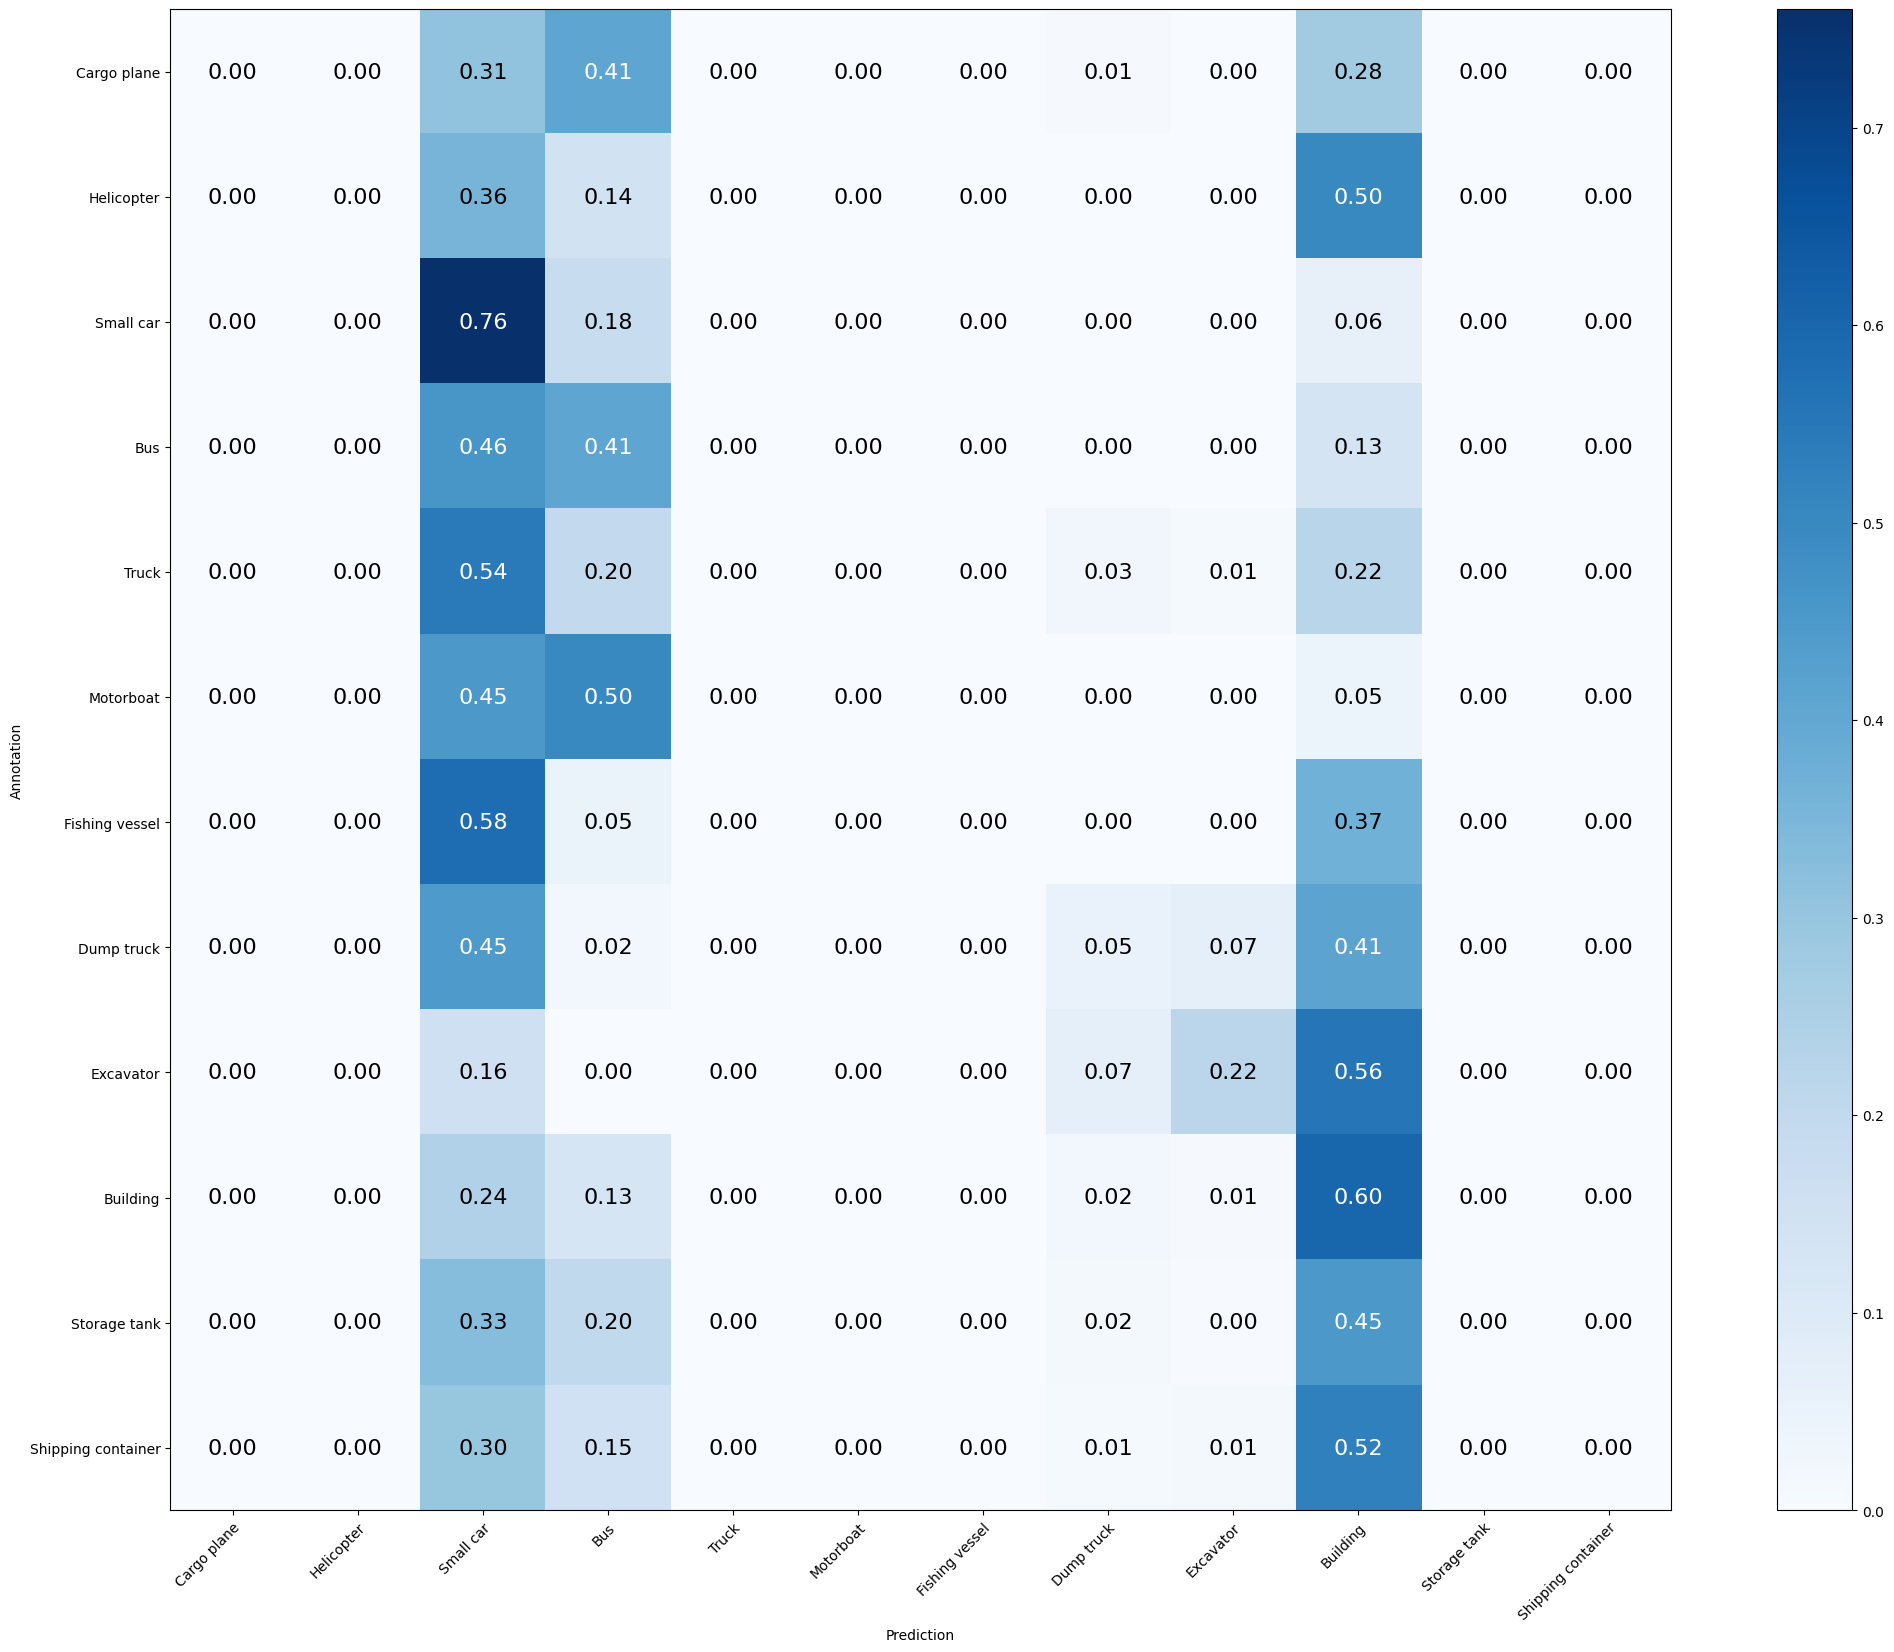

Mean Accuracy: 33.700%
Mean Recall: 17.002%
Mean Precision: 22.046%
> Cargo plane: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 75.991% Precision: 33.958% Specificity: 62.902% Dice: 46.940%
> Bus: Recall: 40.835% Precision: 21.027% Specificity: 82.809% Dice: 27.760%
> Truck: Recall: 0.182% Precision: 100.000% Specificity: 100.000% Dice: 0.364%
> Motorboat: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Dump truck: Recall: 5.263% Precision: 19.403% Specificity: 98.660% Dice: 8.280%
> Excavator: Recall: 21.519% Precision: 49.275% Specificity: 99.150% Dice: 29.956%
> Building: Recall: 60.235% Precision: 40.883% Specificity: 75.524% Dice: 48.707%
> Storage tank: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Shipping container: Recall: 

In [16]:
model.load_weights('model.keras') #, by_name=True)
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)



# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)


# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))


In [ ]:

anns = []
for (dirpath, dirnames, filenames) in os.walk('xview_recognition/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath[18:]+'/'+filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))


model.load_weights('model.keras') #, by_name=True)
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data



with open("predictions.json", "w") as outfile:
    json.dump(predictions_data, outfile)

Number of testing images: 2635


KeyboardInterrupt: 